In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nswe
import math
import muscl2
import serre
import cnoidal
import generalFunctions as gF
import nswe_wbmuscl4 as wb4

%matplotlib inline

In [2]:
def fluxes_periodic(h,hu,n):
    nx = h.shape[0]-4
    h0 = np.zeros(nx+6)
    u0 = np.zeros(nx+6)
    d0 = np.zeros(nx+6)

    h0[3:-3] = h[2:-2]
    u0[3:-3] = hu[2:-2] #hu
    u0 = np.where(h0>1e-10,u0/h0,h0)#hu/h
    
    #periodic bcs
    h0[:3] = h0[-6:-3]
    h0[-3:] = h0[3:6]
    u0[:3] = u0[-6:-3]
    u0[-3:] = u0[3:6]
    
    fp, fm, sc = wb4.fluxes_sources(d0,h0,u0)
    return fp

In [3]:
import sys

def imposeBCDispersive(M,rhs,BCs,h,u,hx,hu,dt):
    
    """
    Impose three boundary conditions for the dispersive part
    
    - Inputs :
        * M : matrix of the FD scheme
        * rhs : right-hand side of the FD scheme
        * BCs : array of dimensions 3x3 containing one TBC in each line, in the form
            [Position,Type,Value,Opt], where
                ::: Position (int) : indicates the point to be modified (0,1,...,-2,-1)
                ::: Type (str) : indicates the type of BC : "Dirichlet"/"Neumann"/"TBC"
                ::: Value (float) : value of the BC
                ::: Opt [int,float,array] : optional coefficients for the TBC; depends on the Type 
        * h,hx,hu : informations from the last computation
        * dt
    """
    gr = 9.81
    
    ### verif number of TBCs
    if BCs.shape[0] != 3 :
        sys.exit("Wrong number of BCs")
        
    ## impose BCs
    for i in range(3) :
        [pos,typ,val] = BCs[i,:3]
        pos = int(pos)
        val = float(val)
        if typ == "Dirichlet" :
            M[pos,:] = 0.
            M[pos,pos] = 1.
            rhs[pos] = -(val*h[pos]-hu[pos] - dt*gr*h[pos]*hx[pos])/dt
        elif typ == "Neumann" :
            M[pos,:] = 0.
            if pos == 0:
                M[0,0] = -h[1]
                M[0,1] = h[0]
                rhs[0] = h[0]*h[1]/dt*(u[1]-u[0] + dt*gr*(hx[1]-hx[0]) - val*dx)
            else:
                M[pos,pos] = h[pos-1]
                M[pos,pos-1] = -h[pos]
                rhs[pos] = h[pos]*h[pos-1]/dt*(u[pos]-u[pos-1] + dt*gr*(hx[pos]-hx[pos-1]) - val*dx)
        elif typ == "Robin" :
            alpha = float(BCs[i,3])
            beta = float(BCs[i,4])
            M[pos,:] = 0.
            if pos == 0 :
                M[0,0] = dt*h[1]*(alpha*dx - beta)
                M[0,1] = beta*dt*h[0]
                rhs[0] = h[0]*h[1]*(\
                                    alpha*dx*(u[0]+dt*gr*hx[0]) + \
                                    beta*(u[1] - u[0] + dt*gr*(hx[1]-hx[0])) - dx*val)
            else :
                M[pos,pos] = dt*h[pos-1]*(alpha*dx + beta)
                M[pos,pos-1] = -beta*dt*h[pos]
                rhs[pos] = h[pos]*h[pos-1]*(\
                                            alpha*dx*(u[pos]+dt*gr*hx[pos]) + \
                                            beta*(u[pos] - u[pos-1] + dt*gr*(hx[pos]-hx[pos-1])) - dx*val)
            
        elif typ == "TBC" :
            sys.exit("TBCs not yet definied!!")
        else :
            sys.exit("Wrong type of TBC!! Please use Dirichlet/Neumann/TBC")
    return M,rhs

In [4]:
def imposePeriodicityDDM(v,vref,ng,side) :
    for i in range(ng) :
        if side == "left":
            v[0+i] = vref[-2*ng+i]
        elif side == "right":
            v[-1-i] = vref[2*ng-(i+1)]
    return v

In [5]:
def modifiedEFDSolverFM(h,u,dx,dt,t,order,BCs,periodic=False,ng=2,side="left",href=None,uref=None):
    
    """
    Finite Difference Solver for the second step of the splitted Serre equations, using the discretization derived
    in the paper of Fabien Marche
    
    - Parameters
        * h,u (1D array) : solution
        * dx,dt,t (integers) : space step, time step, time
        * BCfunction (function) : function that modifies the linear system to impose the BCs
        * BCparam (1D array) : argument for BCfunction; contains the BCs in the form
             BC=[u(left),ux(left),uxx(left),alpha1*u(left) + beta1*ux(right) + gamma1*uxx(right),
                u(right),ux(right),uxx(right),alpha2*u(right) + beta2*ux(right) + gamma2*uxx(right),
                alpha1,beta1,gamma1,alpha2,beta2,gamma2,Fleft,Fright] 
        * periodic (boolean) : indicates if the function is periodic
        
    - Returns
        * u2 (1D array) : solution (velocity)
    """
    
    gr = 9.81
    
    if periodic :
        for v in [uref,href] :
            v = serre.imposePeriodicity(v,ng)

        u = imposePeriodicityDDM(u,uref,ng,side)
        h = imposePeriodicityDDM(h,href,ng,side)

    hu = h*u
    huref = href*uref

    ux = serre.get1d(u,dx,periodic,order=2)
    uxx = serre.get2d(u,dx,periodic,order=2)
    uux = u*ux
    uuxdx = serre.get1d(uux,dx,periodic,order=2)
    hx = serre.get1d(h,dx,periodic,order=2)
    hxx = serre.get2d(h,dx,periodic,order=2)
    h2x = serre.get1d(h*h,dx,periodic,order=2)
    hhx = h*hx

    uxref = serre.get1d(uref,dx,periodic,order=2)
    uxxref = serre.get2d(uref,dx,periodic,order=2)
    uuxref = uref*uxref
    uuxdxref = serre.get1d(uuxref,dx,periodic,order=2)
    hxref = serre.get1d(href,dx,periodic,order=2)
    hxxref = serre.get2d(href,dx,periodic,order=2)
    h2xref = serre.get1d(href*href,dx,periodic,order=2)
    hhxref = href*hxref

    if periodic :
        for v in [uxref,uuxref,uxxref,uuxdxref,h2xref,hxref,hhxref] :
            v = serre.imposePeriodicity(v,ng) 

        ux = imposePeriodicityDDM(ux,uxref,ng,side)
        uux = imposePeriodicityDDM(uux,uuxref,ng,side)
        uxx = imposePeriodicityDDM(uxx,uxxref,ng,side)
        uuxdx = imposePeriodicityDDM(uuxdx,uuxdxref,ng,side)
        h2x = imposePeriodicityDDM(h2x,h2xref,ng,side)
        hx = imposePeriodicityDDM(hx,hxref,ng,side)
        hhx = imposePeriodicityDDM(hhx,hhxref,ng,side)
    
    
    Q = 2.*h*hx*ux*ux + 4./3.*h*h*ux*uxx
    rhs = gr*h*hx + h*Q    
    
    d0 = 1. + hx*hx/3. + h*hxx/3. + 2.*h*h/(3.*dx*dx)
    dp1 = -h*hx/(3.*2.*dx) - h*h/(3.*dx*dx)
    dp1 = dp1[0:-1]
    dm1 = h*hx/(3.*2.*dx) - h*h/(3.*dx*dx)
    dm1 = dm1[1:]
    
    M = np.diag(d0) + np.diag(dp1,1) + np.diag(dm1,-1)

    M[0,:] = 0
    M[-1,:] = 0

    ### Correct it (but in general these lines are replaced by the BC)
    M[0,0] = h[0]*(1. - 3./4.*h2x[0]/dx - 2./3.*h[0]*h[0]/(dx*dx))
    M[0,1] = h[0]*(h2x[0]/dx + 5./3.*h[0]*h[0]/(dx*dx))
    M[0,2] = h[0]*(-1./4.*h2x[0]/dx - 4./3.*h[0]*h[0]/(dx*dx))
    M[0,3] = h[0]*(1./3.*h[0]*h[0]/(dx*dx))

    M[-1,-1] = h[-1]*(1. + 3./4.*h2x[-1]/dx - 2./3.*h[-1]*h[-1]/(dx*dx))
    M[-1,-2] = h[-1]*(-h2x[-1]/dx + 5./3.*h[-1]*h[-1]/(dx*dx))
    M[-1,-3] = h[-1]*(1./4.*h2x[-1]/dx - 4./3.*h[-1]*h[-1]/(dx*dx))
    M[-1,-4] = h[-1]*(1./3.*h[-1]*h[-1]/(dx*dx))
    ######

    np.set_printoptions(threshold=np.nan)
    np.set_printoptions(suppress=True)

    M,rhs = imposeBCDispersive(M,rhs,BCs,h,u,hx,hu,dt)

    z = np.linalg.solve(M,rhs)
    hu2 = hu + dt*(gr*h*hx-z)
    
    return hu2/h

In [6]:
def verifyConvergence(error,diff,eps,criteria):
    if criteria == "error":
        if error < eps :
            return True
    elif criteria == "diffIteration" :
        if diff < eps :
            return True
    else :
        print("WRONG CRITERIA")
    return False

In [66]:
import sys

nan = float('nan')

# solve the Serre equation
def splitSerreDDM(x1,x2,h1,h2,u1,u2,x,h,u,href,uref,t0,tmax,dx,nx,vardt = True, dt = 0.05,
                  splitSteps = 3, periodic=False,ghostcells = 2,
                  BCfunctionFV = serre.openDomain, BCparamFV = None,fvsolver=muscl2.fluxes2,fvTimesolver=serre.RK4,
                  fdsolver=serre.EFDSolverFM,orderFD=2,
                  DDMfirstStep = False,dispIBC="Dirichlet",dispIBCextra=None,
                  nitermax=100,criteriaCV="error",epsCV=1e-9):
    
    """
    Solves the splitted Serre equations using a DDM (with two non-overlapping subdomains)
    Inputs with double asterisk (**) will be revised or removed
    
    Inputs
    * x1,x2 : points of each subdomain
    * h1,h2,u1,u2 : initial solutions in each subdomain
    * href,uref : referential solution (on the monodomain)
    * dx,nx
    * vardt (boolean) : if true, compute dt at each time step in function of CFL
    * splitsteps : type of splitting
    * periodic (boolean)
    * ghostcells : number of ghost cells in each side (used in the FV scheme)
    ** BCfunctionFV : function to impose BCs for the advection part
    ** BCparamFV : parameters
    * fvsolver : solver for the advection part
    * fvtimesolver : time advancing scheme for the advection part
    * fdsolver : solver for the dispersive part
    * orderFD : order of fdsolver
    * DDMfirststep (boolean) : if false, advection aprt is solved in the monodomain
    * dispIBC : type of interface boundary condition for the dispersive part (Dirichlet,Neumann,Robin,TBC)
    * dispIBCextra : possible coefficients for the IBC
    * nitermax : max number of iterations for the DDM
    * criteriaCV : criteria for convergence of the DDM (error,diffIteration)
    * epsCV : limit for applying criteriaCV
    """
        
    it = 0 # temporal index
    t = t0
    grav = 9.8
    
    uall1 = np.copy(u1)
    hall1 = np.copy(h1)
    tall1 = np.ones(1)*t0
    uall2 = np.copy(u2)
    hall2 = np.copy(h2)
    tall2 = np.ones(1)*t0
    
    print(r'CFL = %f' %(dt/(dx*dx*dx)))
    
    niter = 0
    while t < tmax and dt > 1e-9:
        if vardt : ## compute dt from CFL condition
            if (np.amax(np.absolute(u)) + np.sqrt(grav*np.amax(h))) > 1.e-6:
                dt = dx/(np.amax(np.absolute(u)) + np.sqrt(grav*np.amax(h)))
            print(r'dt = %f; t = %f' %(dt,t))
            
        t = t+dt
        it = it + 1 
               
        hu1 = h1*u1
        hu2 = h2*u2
        
        h1x = serre.get1d(h1,dx,periodic,order=2)
        h2x = serre.get1d(h2,dx,periodic,order=2)
        
        h1prev = np.copy(h1)
        hu1prev = np.copy(hu1)
        h2prev = np.copy(h2)
        hu2prev = np.copy(hu2)
        
        Nddm = x1.size ## middle point
        N = uref.shape[0]
        Nddm1 = x1.size
        Nddm2 = x2.size
        
        #x = np.concatenate((x1[:-1],x2))     
        #h = np.concatenate((h1[:-1],h2))
        #hu = np.concatenate((hu1[:-1],hu2))
        hu = h*u
        huref = href*uref

        if periodic :
            h,hu = serre.periodicDomainTwoGC(h,hu,BCparamFV,dx,t)
  
        if splitSteps == 2 : ## Adv + Disp
         
            niter = 0
            if DDMfirstStep : ## advection step solved by DDM
                while niter < nitermax :
                    
                    niter = niter+1
                    
                    bcparamA1 = np.array([0.,0.,h2[0],hu2[0],0.,1.,0.,1.,1.,0.,1.,0.,0.])
                    bcparamA2 = np.array([0.,0.,h1[-1],hu1[-1],0.,1.,0.,1.,1.,0.,1.,0.,0.])
            
                    h1mm = np.copy(h1)
                    h2mm = np.copy(h2)
                    hu1mm = np.copy(hu1)
                    hu2mm = np.copy(hu2)
                    
                    h1,hu1 = fvTimesolver(x1,h1prev,hu1prev,fvsolver,BCfunctionFV,BCparamFV,dx,dt,nx,t,ng=ghostcells)
                    h2,hu2 = fvTimesolver(x2,h2prev,hu2prev,fvsolver,BCfunctionFV,BCparamFV,dx,dt,nx,t,ng=ghostcells)
                    
                    errorh = np.linalg.norm(h1-href[:Nddm,1]) + np.linalg.norm(h2-href[Nddm-1:,1])
                    errorhu = np.linalg.norm(hu1-huref[:Nddm,1]) + np.linalg.norm(hu2-huref[Nddm-1:,1])
                    diffh = np.linalg.norm(h1-h1mm) + np.linalg.norm(h2-h2mm)
                    diffhu = np.linalg.norm(hu1-hu1mm) + np.linalg.norm(hu2-hu2mm)
                    print("DDM step 1 h",niter,errorh,diffh)
                    print("DDM step 1 hu",niter,errorhu,diffhu)
                    if verifyConvergence(errorh+errorhu,diffh+diffhu,epsCV,criteriaCV):
                        break
            else: ## solve advection step in the monodomain
                if periodic :
                    BCfunctionFV = serre.periodicDomainTwoGC
                h,hu = fvTimesolver(x,h,hu,fvsolver,BCfunctionFV,BCparamFV,dx,dt,nx,t,ng=ghostcells)
                ## get the solutions in each subdomain
                #h1 = h[:Nddm]
                #h2 = h[Nddm-1:]
                #hu1 = hu[:Nddm]
                #hu2 = hu[Nddm-1:]
                print(h1.size,h2.size)
                h1 = h[:Nddm1]
                h2 = h[N-Nddm2:]
                print(h1.size,h2.size)
                hu1 = hu[:Nddm1]
                hu2 = hu[N-Nddm2:]
            
            print(h1.shape,h2.shape)
            u = np.where(h[:]>1e-5, hu[:]/h[:], 0.)
            u1 = np.where(h1[:]>1e-5, hu1[:]/h1[:], 0.)
            u2 = np.where(h2[:]>1e-5, hu2[:]/h2[:], 0.)
            u1prev = np.copy(u1)
            u2prev = np.copy(u2)
                                 
            niter = 0

            ### Dispersive step
            while niter < nitermax :

                niter = niter + 1
                if niter < 1:
                    u1init = np.random.rand(u1.size)
                    u2init = np.random.rand(u2.size)
                else:
                    u1init = u1[:N-Nddm2+1]
                    u2init = u2[Nddm1+Nddm2-(N+1):]  
                    
                #print(u1.size,u2.size,u1init.size,u2init.size)
                #print(x1[N-Nddm2],x2[0],x1[-1],x2[Nddm1+Nddm2-(N+1)])
                                        
                ## Periodic solution
                if periodic :
                    uPerL = uref[0,it]
                    uPerLL = uref[1,it]
                    uPerR = uref[-1,it]
                    uPerRR = uref[-2,it]
                
                if dispIBC == "Dirichlet" :
                    BCdisp1 = np.array([[0,"Dirichlet",uPerL],
                                        [1,"Dirichlet",uPerLL],
                                        [-1,"Dirichlet",u2init[0]]])
                    BCdisp2 = np.array([[0,"Dirichlet",u1init[-1]],
                                        [-2,"Dirichlet",uPerRR],
                                        [-1,"Dirichlet",uPerR]])
                elif dispIBC == "Neumann" :
                    BCdisp1 = np.array([[0,"Dirichlet",uPerL],
                                        [1,"Dirichlet",uPerLL],
                                        [-1,"Neumann",(u2init[1]-u2init[0])/dx]])
                    BCdisp2 = np.array([[0,"Neumann",(u1init[-1]-u1init[-2])/dx],
                                        [-2,"Dirichlet",uPerRR],
                                        [-1,"Dirichlet",uPerR]])
                elif dispIBC == "Robin" :
                    alpha1 = dispIBCextra[0]
                    beta1 = dispIBCextra[1]
                    alpha2 = dispIBCextra[2]
                    beta2 = dispIBCextra[3]
                    BCdisp1 = np.array([[0,"Dirichlet",uPerL,0,0],
                                        [1,"Dirichlet",uPerLL,0,0],
                                        [-1,"Robin",alpha1*u2init[0] + beta1*(u2init[1]-u2init[0])/dx,alpha1,beta1]])  
                    BCdisp2 = np.array([[0,"Robin",alpha2*u1init[-1] + beta2*(u1init[-1]-u1init[-2])/dx,alpha2,beta2],
                                        [-2,"Dirichlet",uPerRR,0,0],
                                        [-1,"Dirichlet",uPerR,0,0]])
                elif dispIBC == "TBC":
                    sys.exit("TBC not yet defined")
                    

              
                u1mm = np.copy(u1)
                u2mm = np.copy(u2)
                u1 = fdsolver(h1,u1prev,dx,dt,t,orderFD,BCdisp1,periodic,ng=ghostcells,side="left",
                              uref=u,href=h)
                u2 = fdsolver(h2,u2prev,dx,dt,t,orderFD,BCdisp2,periodic,ng=ghostcells,side="right",
                              uref=u,href=h)
                                
                #error = np.linalg.norm(u1-uref[:Nddm,it]) + np.linalg.norm(u2-uref[Nddm-1:,it])
                error = np.linalg.norm(u1-uref[:Nddm1,it]) + np.linalg.norm(u2-uref[N-Nddm2:,it])
                diff = np.linalg.norm(u1-u1mm) + np.linalg.norm(u2-u2mm)
                
                print("DDM step 2",niter,error,diff)
                if verifyConvergence(error,diff,epsCV,criteriaCV):
                        break

        hall1 = np.column_stack((hall1,h1))
        uall1 = np.column_stack((uall1,u1))
        tall1 = np.hstack((tall1,t*np.ones(1)))
        hall2 = np.column_stack((hall2,h2))
        uall2 = np.column_stack((uall2,u2))
        tall2 = np.hstack((tall2,t*np.ones(1)))       
    return hall1,uall1,tall1,hall2,uall2,tall2,niter,error

# Test case 1 : analytical solution (cnoidal solution)

## Monodomain problem

In [36]:
reload(serre)
dt = 0.05

### construct the initial solution
a0 = 0.3
a1 = 0.1
k = 0.99
g = 9.81
t = 0.0

lam, h0 = cnoidal.WaveLengthDepth(k,a0,a1)

### discretize space
L = 2*lam
xmin = -L
xmax = L
nx = 101
dx1 = (xmax-xmin)/(nx)
x,dx = serre.discretizeSpace(xmin-2.*dx1,xmax+2.*dx1,nx+4)

h,u = cnoidal.analyticalSolution(x[2:-2],t,k,a0,a1)
h = serre.extend2GhostCells(h,2)
u = serre.extend2GhostCells(u,2)
h,u = serre.periodicDomainTwoGC(h,u,None,dx,0)

tmax = 4.
#### MONODOMAIN PROBLEM
## Serre equation
hall1,uall1,tall1 = serre.splitSerre(x,h,u,0,tmax,serre.periodicDomainTwoGC,
                                     serre.periodicDomain2TwoGC,None,None,dx,nx,vardt = False, dt = 0.05,
                                     splitSteps=2,order=2, periodic=True,
                                     fvsolver = fluxes_periodic, fdsolver = serre.EFDSolverFM, ghostcells=2)
## Only NSWE
hall2,uall2,tall2 = serre.NSWE(x,h,u,0,tmax,serre.periodicDomainTwoGC,None,dx,nx,vardt = False, dt = 0.05,
                              fvsolver=fluxes_periodic, ghostcells=2)

## Exact solution
hallexact = np.copy(hall1)
uallexact = np.copy(uall1)
for i in range (tall1.size):
    hallexact[:,i],uallexact[:,i] = cnoidal.analyticalSolution(x,tall1[i],k,a0,a1)

    
## Parameters for plotting    
umin = np.amin(np.concatenate((uall1,uall2)))
umax = np.amax(np.concatenate((uall1,uall2)))
hmin = np.amin(np.concatenate((hall1,hall2)))
hmax = np.amax(np.concatenate((hall1,hall2)))

CFL = 5.935090


/Users/joaocaldas/Softwares/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in divide


CFL = 5.935090


*** Plotting animation ...



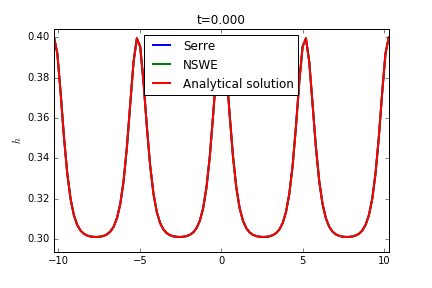
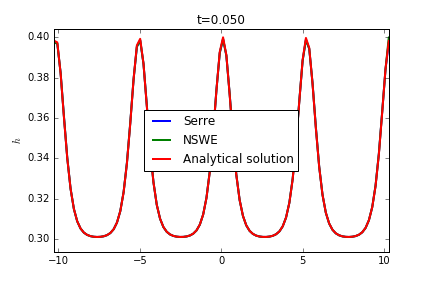
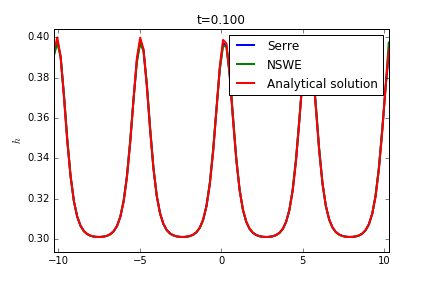
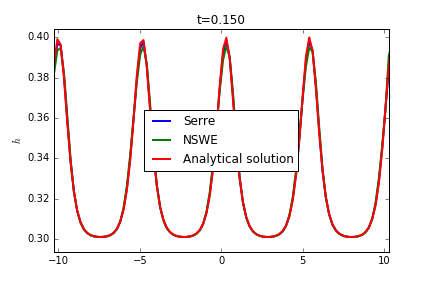
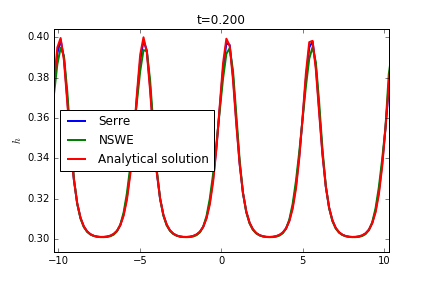
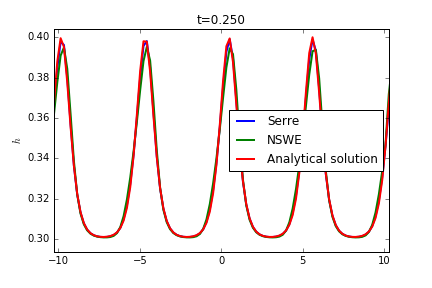
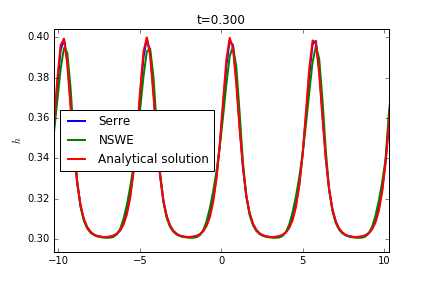
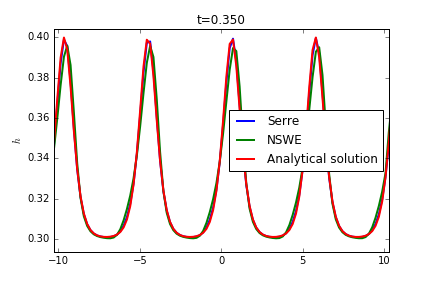
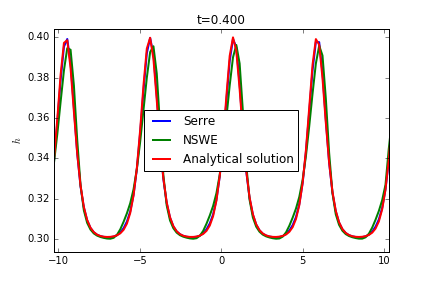
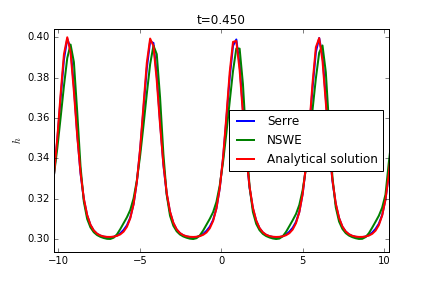
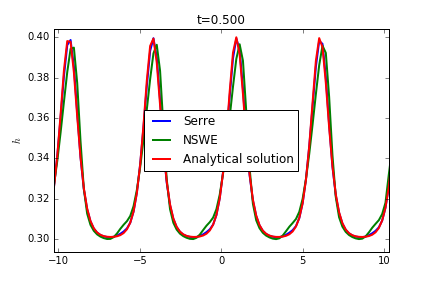
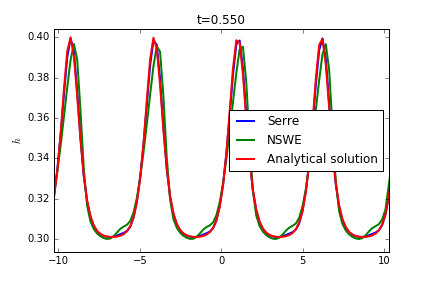
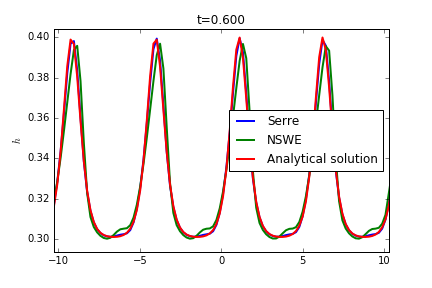
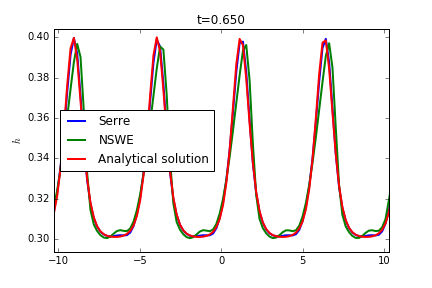
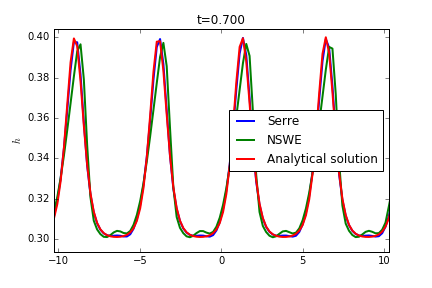
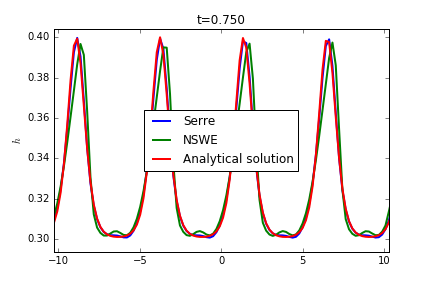
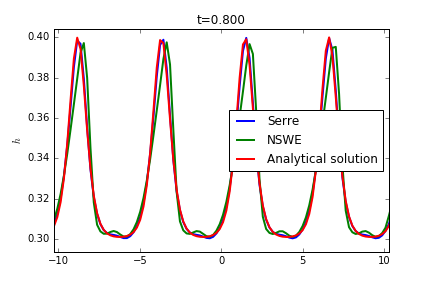
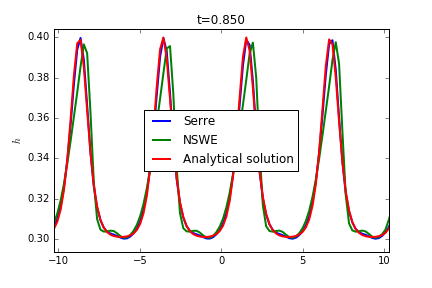
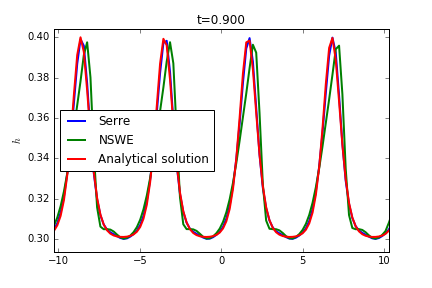
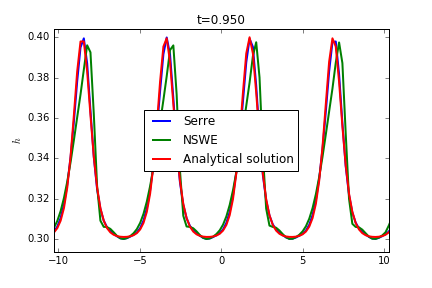
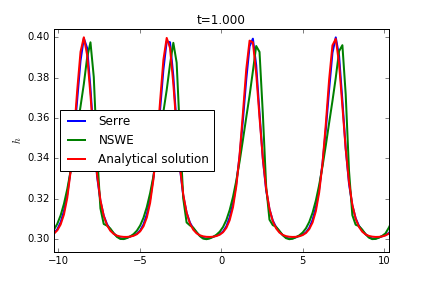
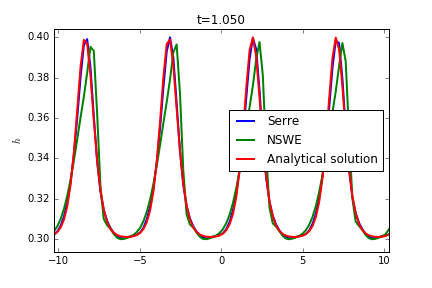
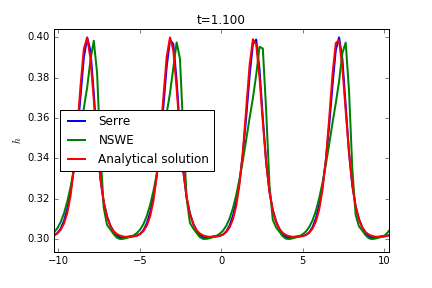
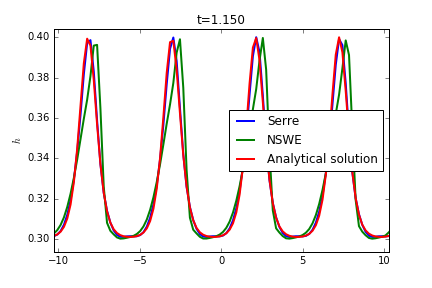
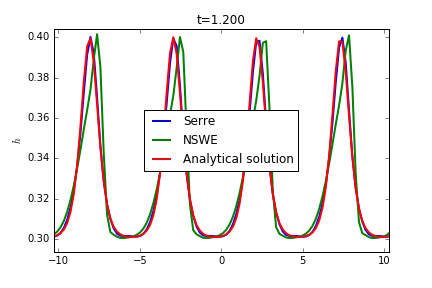
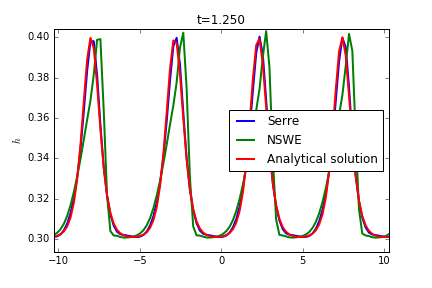
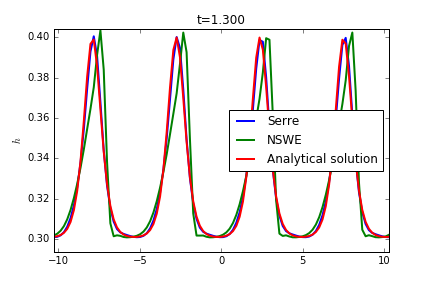
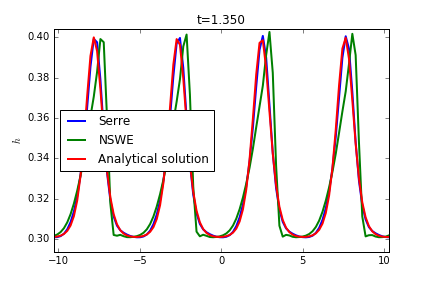
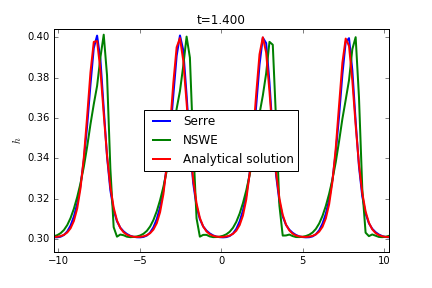
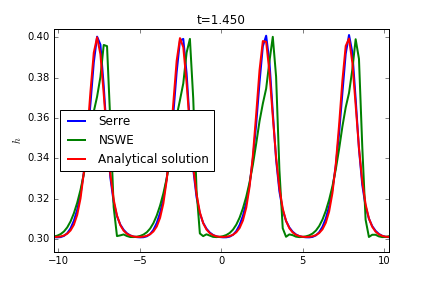
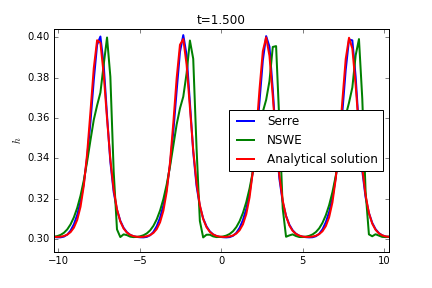
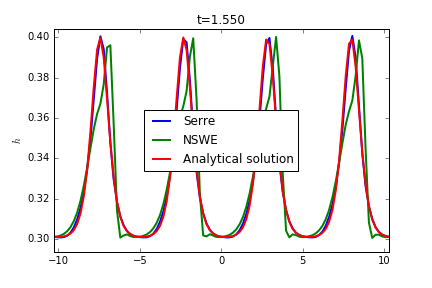
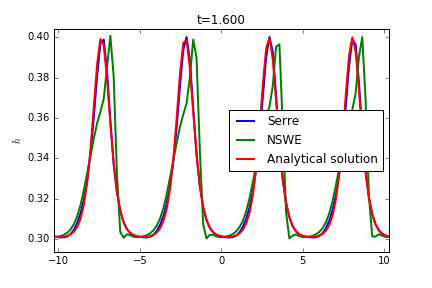
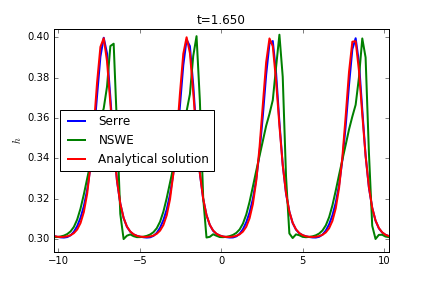
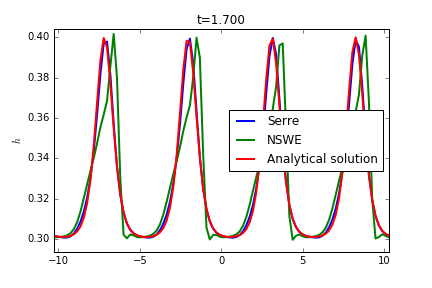
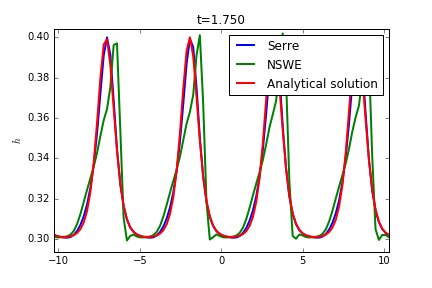
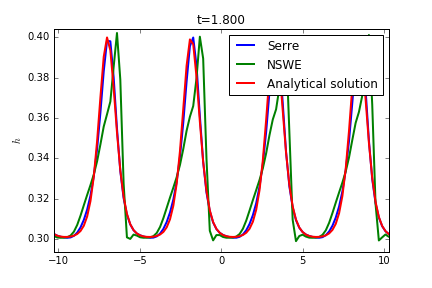
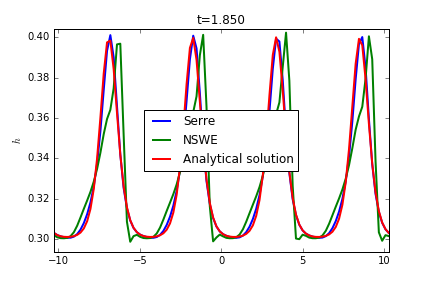
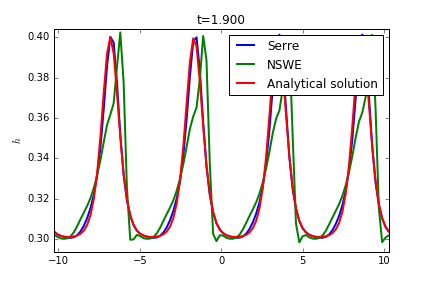
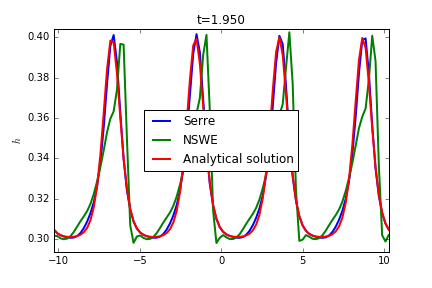
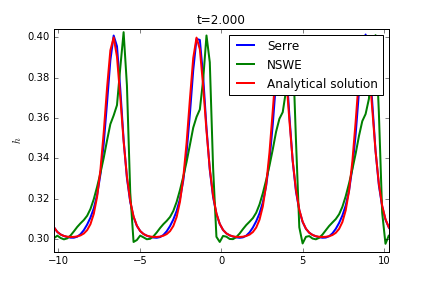
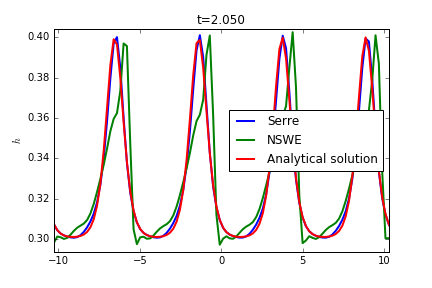
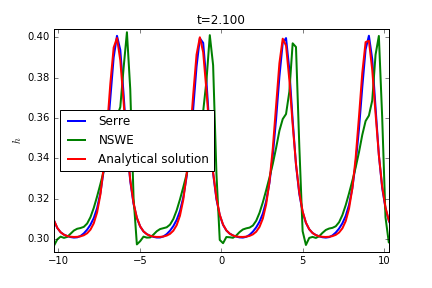
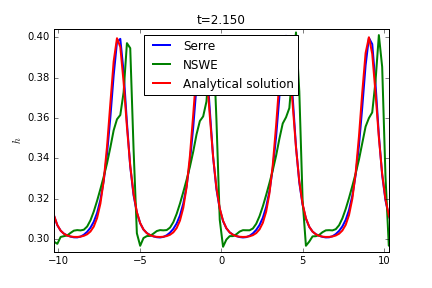
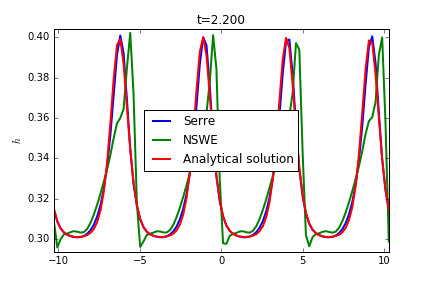
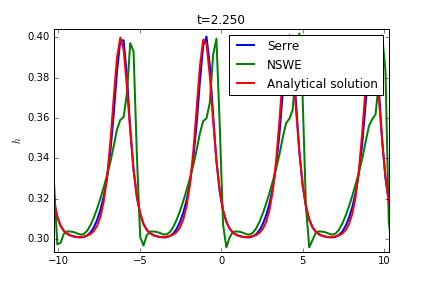
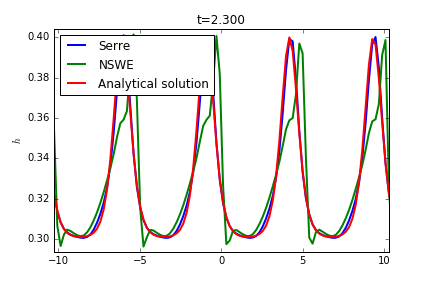
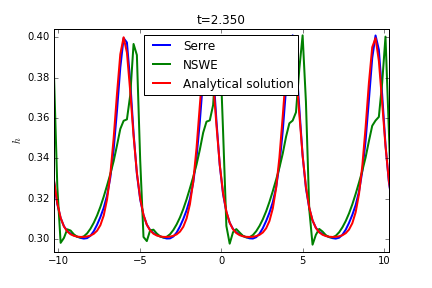
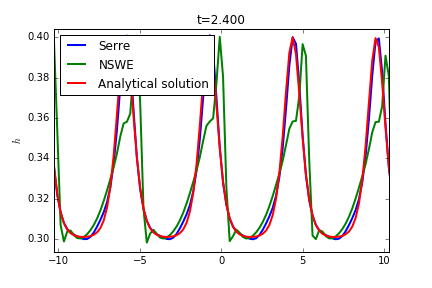
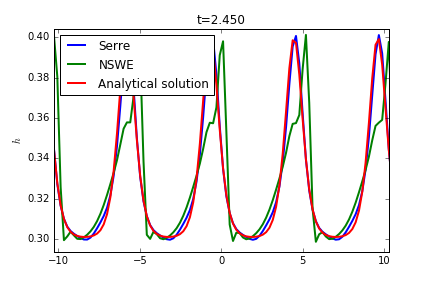
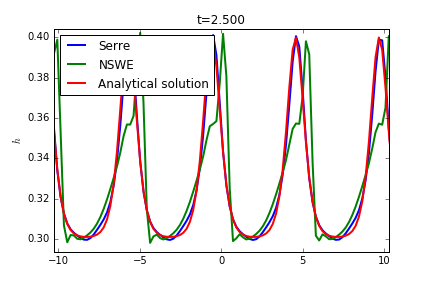
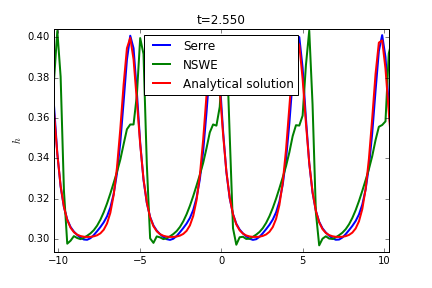
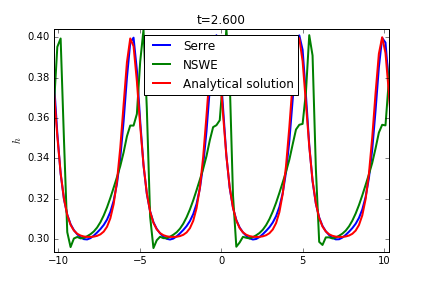
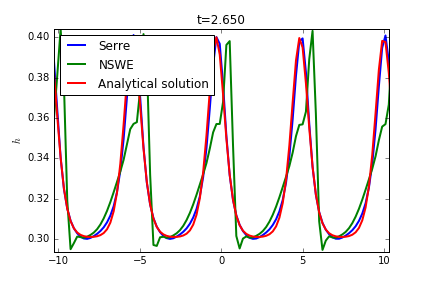
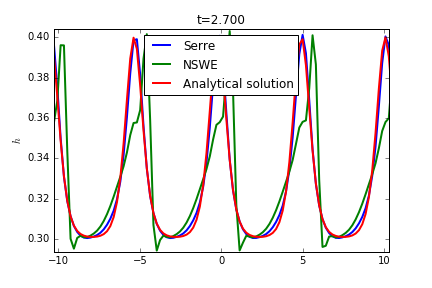
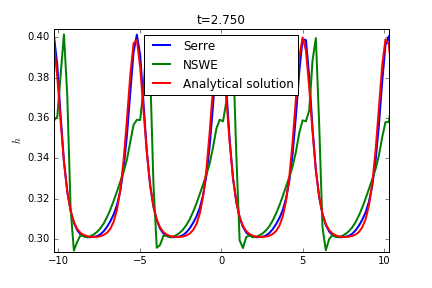
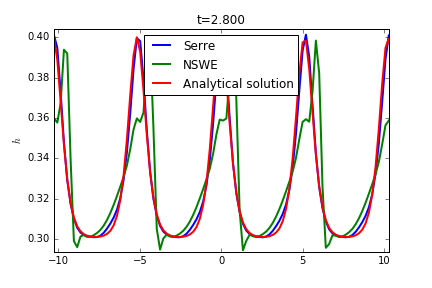
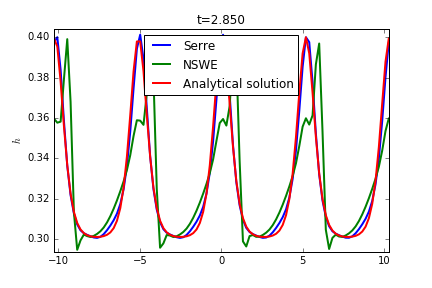
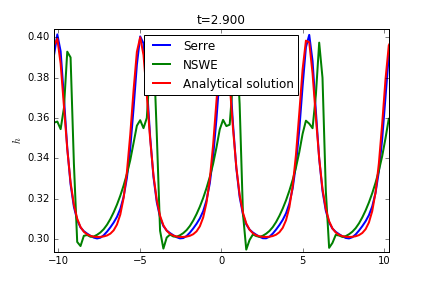
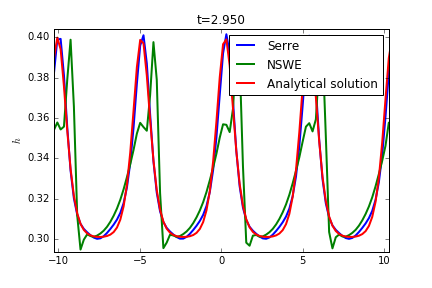
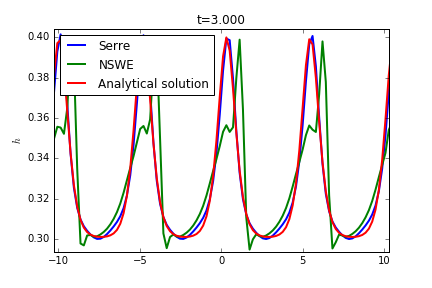
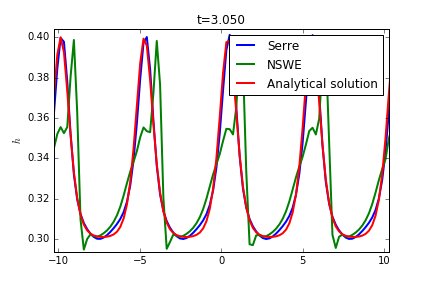
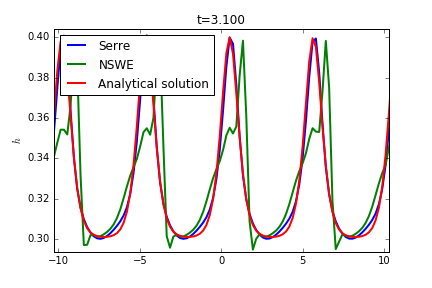
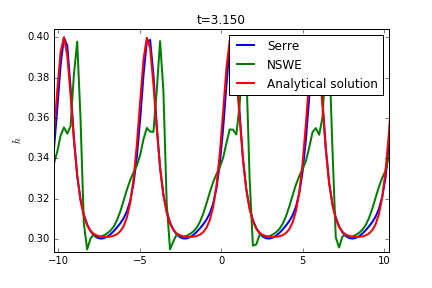
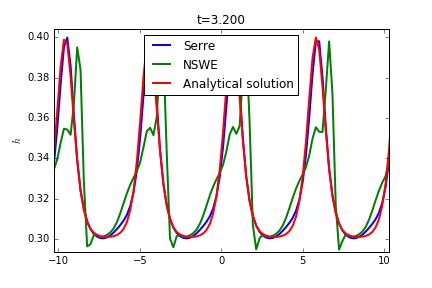
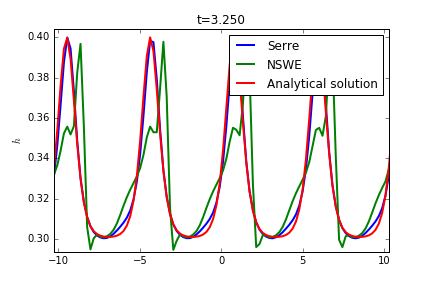
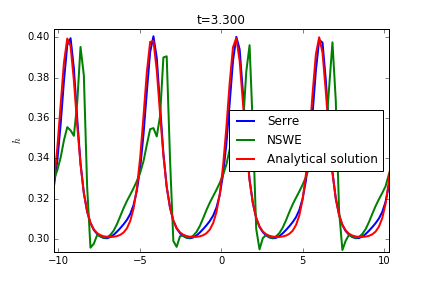
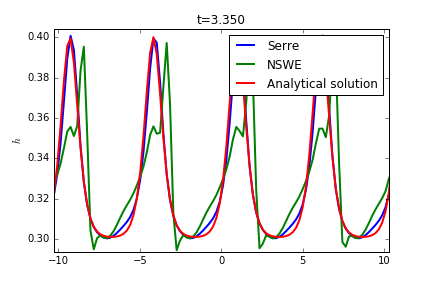
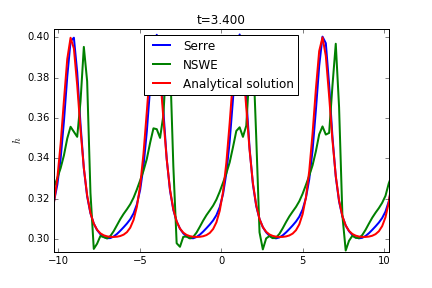
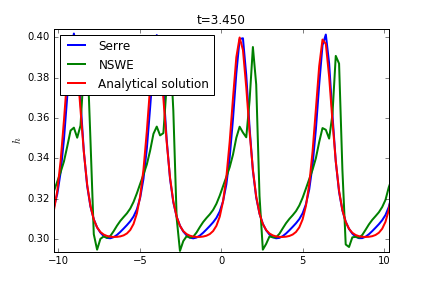
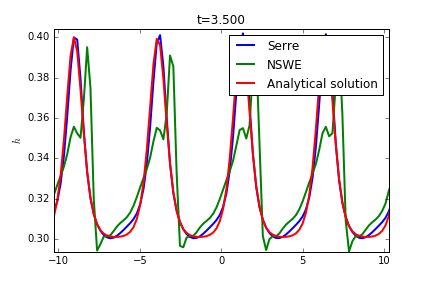
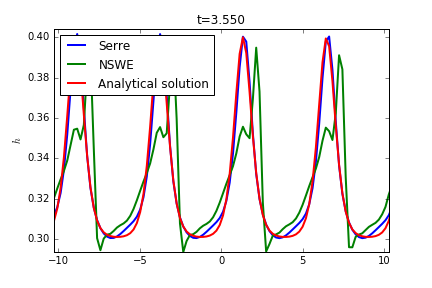
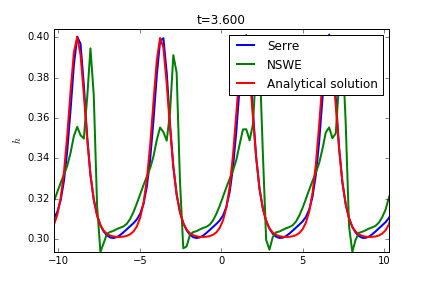
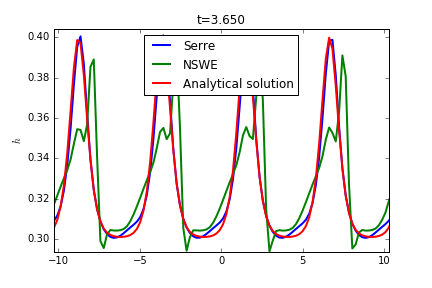
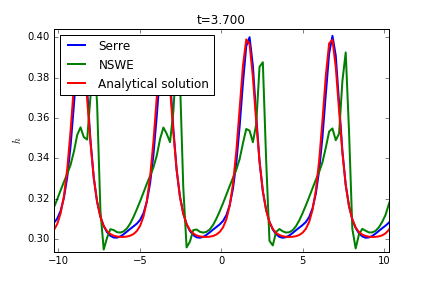
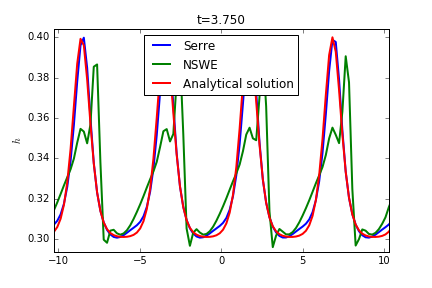
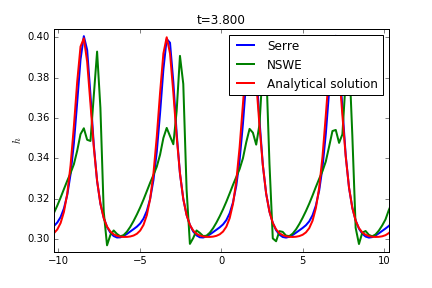
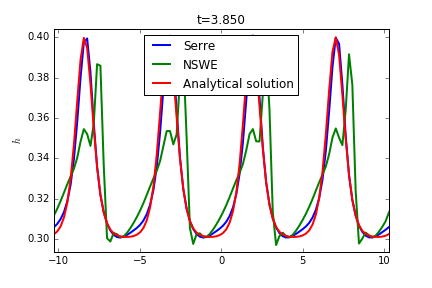
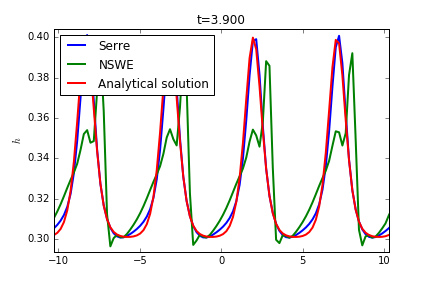
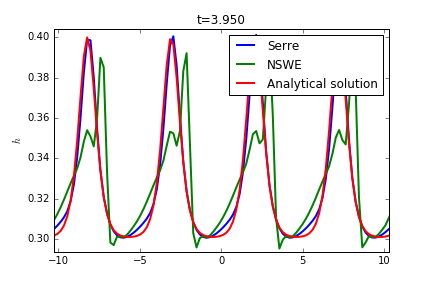
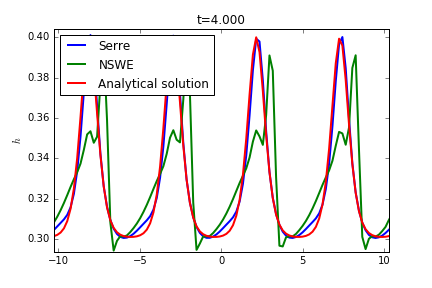
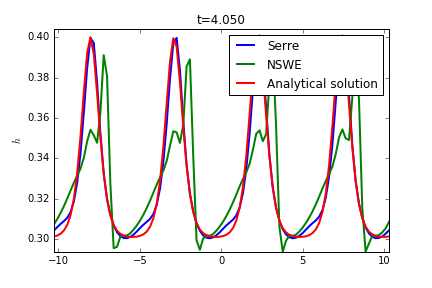

In [32]:
lb = ["Serre","NSWE", "Analytical solution"]
gF.plotAnimationNSolutions(3,x,np.array([hall1,hall2,hallexact]),tall1,xmin,xmax,hmin,hmax,lb,ylabel=r'$h$')

## DDM

In [61]:
reload(serre)

#DDM
Nddm = (nx+4)/2+1 ## middle point
print(Nddm)
t0 = 0.

## divide domains and solutions
x1 = x[:Nddm]
x2 = x[Nddm-1:]
u1 = u[:Nddm]
u2 = u[Nddm-1:]
h1 = h[:Nddm]
h2 = h[Nddm-1:]

## divide domains and solutions
ov = 10 # size of overlap
x1 = x[:Nddm+ov]
x2 = x[Nddm-1-ov:]
u1 = u[:Nddm+ov]
u2 = u[Nddm-1-ov:]
h1 = h[:Nddm+ov]
h2 = h[Nddm-1-ov:]

h1prev = np.copy(h1)
h2prev = np.copy(h2)
u1prev = np.copy(u1)
u2prev = np.copy(u2)

dt = 0.05
tmax = 4.

print(x1.shape,x2.shape)

53
((63,), (63,))


### IBC = Dirichlet

In [68]:
tmax = 4.
robinCoef = np.array([1.,0.,1.,0.])
hall1Dir,uall1Dir,tall1Dir,\
hall2Dir,uall2Dir,tall2Dir,niterDir,errorDir = splitSerreDDM(x1,x2,h1,h2,u1,u2,x,h,u,hall1,uall1,t0,tmax,
                                                            dx,nx,vardt = False, dt = dt,
                                                            splitSteps = 2, periodic=True,
                                                            fvsolver = fluxes_periodic,
                                                            fdsolver = modifiedEFDSolverFM,
                                                            ghostcells = 2,nitermax=10,
                                                            dispIBC = "Robin", dispIBCextra = robinCoef,
                                                            DDMfirstStep = False, criteriaCV="diffIteration")

CFL = 5.935090
(63, 63)
(63, 63)
((63,), (63,))
('DDM step 2', 1, 0.0020299526299249987, 0.12384157850323185)
('DDM step 2', 2, 0.0012890645132596617, 0.0012001959162200779)
('DDM step 2', 3, 0.0012890645136079458, 1.060074085119802e-12)
(63, 63)
(63, 63)
((63,), (63,))
('DDM step 2', 1, 0.088707897809951974, 0.10602927147727875)
('DDM step 2', 2, 0.088640235082559776, 0.0013676284508335797)
('DDM step 2', 3, 0.08864023508257643, 1.0589341656737527e-12)
(63, 63)
(63, 63)
((63,), (63,))
('DDM step 2', 1, 0.15847926592783795, 0.097878049789058105)
('DDM step 2', 2, 0.15839428900268587, 0.0016210831803982367)
('DDM step 2', 3, 0.15839428900271793, 2.1177453552220272e-12)
(63, 63)
(63, 63)
((63,), (63,))
('DDM step 2', 1, 0.2056904898992318, 0.095507274864805911)
('DDM step 2', 2, 0.20556496517360673, 0.0019846289711217008)
('DDM step 2', 3, 0.20556496517364053, 2.1180675679726046e-12)
(63, 63)
(63, 63)
((63,), (63,))
('DDM step 2', 1, 0.23480386189265826, 0.095413576962080859)
('DDM step 

/Users/joaocaldas/Softwares/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in divide


(63, 63)
(63, 63)
((63,), (63,))
('DDM step 2', 1, 0.34123763913610311, 0.11097563027876174)
('DDM step 2', 2, 0.34075140240875557, 0.0052462150575311953)
('DDM step 2', 3, 0.34075140240889124, 7.5165320843627322e-12)
(63, 63)
(63, 63)
((63,), (63,))
('DDM step 2', 1, 0.38113264330579555, 0.11965881779376916)
('DDM step 2', 2, 0.38092138380467522, 0.0037252035625766305)
('DDM step 2', 3, 0.38092138380475626, 5.5054258587131368e-12)
(63, 63)
(63, 63)
((63,), (63,))
('DDM step 2', 1, 0.42269161466360861, 0.12869349919619139)
('DDM step 2', 2, 0.42268838818911603, 0.0010181730489947592)
('DDM step 2', 3, 0.4226883881891032, 1.3782808828507491e-12)
(63, 63)
(63, 63)
((63,), (63,))
('DDM step 2', 1, 0.46517993365299887, 0.13573916818302365)
('DDM step 2', 2, 0.46424458571084792, 0.0087507620244049768)
('DDM step 2', 3, 0.46424458571078409, 1.2072846154867441e-11)
(63, 63)
(63, 63)
((63,), (63,))
('DDM step 2', 1, 0.51036965325361339, 0.13796487461359339)
('DDM step 2', 2, 0.5061172424010396

### IBC = Neumann

In [69]:
tmax=4.
robinCoef = np.array([0.,1.,0.,1.])
hall1Neu,uall1Neu,tall1Neu,\
hall2Neu,uall2Neu,tall2Neu,niterNeu,errorNeu = splitSerreDDM(x1,x2,h1,h2,u1,u2,x,h,u,hall1,uall1,t0,tmax,
                                                            dx,nx,vardt = False, dt = dt,
                                                            splitSteps = 2, periodic=True,
                                                            fvsolver = fluxes_periodic,
                                                            fdsolver = modifiedEFDSolverFM,
                                                            ghostcells = 2,nitermax=10,
                                                            dispIBC = "Robin", dispIBCextra = robinCoef,
                                                            DDMfirstStep = False, criteriaCV="diffIteration")

CFL = 5.935090
(63, 63)
(63, 63)
((63,), (63,))
('DDM step 2', 1, 0.0087929528154224636, 0.12425889321688929)
('DDM step 2', 2, 0.0084930114744679493, 0.00085781985192603461)
('DDM step 2', 3, 0.008493011474913631, 1.2129289385212338e-12)
(63, 63)
(63, 63)
((63,), (63,))
('DDM step 2', 1, 0.089025304639131594, 0.10669288066165936)
('DDM step 2', 2, 0.08896528905053154, 0.00097302919317587215)
('DDM step 2', 3, 0.088965289050577351, 1.386491958029753e-12)
(63, 63)
(63, 63)
((63,), (63,))
('DDM step 2', 1, 0.15852748375707049, 0.098946349546925799)
('DDM step 2', 2, 0.1584868955299133, 0.001149176304473749)
('DDM step 2', 3, 0.15848689552995787, 1.623916925826778e-12)
(63, 63)
(63, 63)
((63,), (63,))
('DDM step 2', 1, 0.20555981321660854, 0.097156543152753683)
('DDM step 2', 2, 0.20552194244497024, 0.0014052521222455972)
('DDM step 2', 3, 0.20552194244502286, 1.9831327208262544e-12)
(63, 63)
(63, 63)
((63,), (63,))
('DDM step 2', 1, 0.23446181604998234, 0.097836643497099085)
('DDM step 2

/Users/joaocaldas/Softwares/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in divide


(63, 63)
(63, 63)
((63,), (63,))
('DDM step 2', 1, 0.34135926836938724, 0.12067174190772456)
('DDM step 2', 2, 0.34129991931760634, 0.0013742205772221462)
('DDM step 2', 3, 0.34129991931753667, 2.0096551016086297e-12)
(63, 63)
(63, 63)
((63,), (63,))
('DDM step 2', 1, 0.38406781927005929, 0.13217274187369421)
('DDM step 2', 2, 0.38470269006105823, 0.0040983644664447372)
('DDM step 2', 3, 0.38470269006072438, 5.7182054382305062e-12)
(63, 63)
(63, 63)
((63,), (63,))
('DDM step 2', 1, 0.42958912861811371, 0.13935919521502346)
('DDM step 2', 2, 0.43232916829256085, 0.011444801398370855)
('DDM step 2', 3, 0.43232916829189355, 1.6054273763545896e-11)
(63, 63)
(63, 63)
((63,), (63,))
('DDM step 2', 1, 0.47161045638934912, 0.13642768274236286)
('DDM step 2', 2, 0.47739008797052951, 0.021150724151341109)
('DDM step 2', 3, 0.47739008796953131, 2.9816308812314724e-11)
(63, 63)
(63, 63)
((63,), (63,))
('DDM step 2', 1, 0.50491050558562867, 0.14653283987283891)
('DDM step 2', 2, 0.51141472599188043

### IBC = Robin (searching best coefficient)

In [70]:
tmax = dt
coefs = np.append(np.arange(0.,20.,1.),np.arange(2.5,3.5,0.1))
coefs = np.append(coefs,np.arange(2.75,2.85,0.01))
coefs = np.append(coefs,np.sqrt(h0)/3.)
niterTests = np.zeros((1,3))
for coef in coefs:
    print("*************")
    print(coef)
    robinCoef = np.array([coef,1.,-coef,1.])
    hall1Rob,uall1Rob,tall1Rob,\
    hall2Rob,uall2Rob,tall2Rob,niterRob,errorRob = splitSerreDDM(x1,x2,h1,h2,u1,u2,x,h,u,hall1,uall1,t0,tmax,
                                                                dx,nx,vardt = False, dt = dt,
                                                                splitSteps = 2, periodic=True,
                                                                fvsolver = fluxes_periodic,
                                                                fdsolver = modifiedEFDSolverFM,
                                                                ghostcells = 2,nitermax=20,
                                                                dispIBC = "Robin", dispIBCextra = robinCoef,
                                                                DDMfirstStep = False, criteriaCV="diffIteration")
    niterTests = np.vstack((niterTests,np.array([coef,niterRob,errorRob])))

niterTests = np.delete(niterTests,0,0)  ## delete first line (0,0)
## search fastest
criteria = "error"
if criteria == "speed":
    idxMin = np.argmin(niterTests[:,1])
elif criteria == "error":
    idxMin = np.argmin(niterTests[:,2])    
coefMin = niterTests[idxMin,0]
print("Fastest coefficient : ",coefMin,niterTests[idxMin,1],niterTests[idxMin,2])

*************
0.0
CFL = 5.935090
(63, 63)
(63, 63)
((63,), (63,))
('DDM step 2', 1, 0.0087929528154224636, 0.12425889321688929)
('DDM step 2', 2, 0.0084930114744679493, 0.00085781985192603461)
('DDM step 2', 3, 0.008493011474913631, 1.2129289385212338e-12)
*************
1.0
CFL = 5.935090
(63, 63)
(63, 63)
((63,), (63,))
('DDM step 2', 1, 0.0066022788130916778, 0.12409100283285929)
('DDM step 2', 2, 0.0065165961134807503, 0.00037903147213087774)
('DDM step 2', 3, 0.0065165961137255398, 2.4622784065172657e-13)
*************
2.0
CFL = 5.935090
(63, 63)
(63, 63)
((63,), (63,))
('DDM step 2', 1, 0.0052544895602127314, 0.12400810228538572)
('DDM step 2', 2, 0.0052982941296427525, 8.0973102954136656e-05)
('DDM step 2', 3, 0.0052982941298405899, 1.9956831933391882e-13)
*************
3.0
CFL = 5.935090
(63, 63)
(63, 63)
((63,), (63,))
('DDM step 2', 1, 0.0043502445305232187, 0.12396107587406263)
('DDM step 2', 2, 0.0044770920565828098, 0.000135439170860241)
('DDM step 2', 3, 0.0044770920565828

/Users/joaocaldas/Softwares/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in divide


(63, 63)
(63, 63)
((63,), (63,))
('DDM step 2', 1, 0.0024078222419924157, 0.12388125655845292)
('DDM step 2', 2, 0.0026350521014745837, 0.00059939098247746092)
('DDM step 2', 3, 0.0026350521014745837, 0.0)
*************
9.0
CFL = 5.935090
(63, 63)
(63, 63)
((63,), (63,))
('DDM step 2', 1, 0.002248899006041514, 0.12387549406892565)
('DDM step 2', 2, 0.0024607178931875559, 0.00064824333531133464)
('DDM step 2', 3, 0.0024607178940142522, 8.6078928357852998e-13)
*************
10.0
CFL = 5.935090
(63, 63)
(63, 63)
((63,), (63,))
('DDM step 2', 1, 0.0021270598978643351, 0.12387095081675864)
('DDM step 2', 2, 0.0023165739792732334, 0.00068974857411653373)
('DDM step 2', 3, 0.0023165739800333047, 7.9600650031154927e-13)
*************
11.0
CFL = 5.935090
(63, 63)
(63, 63)
((63,), (63,))
('DDM step 2', 1, 0.0020340392987987909, 0.12386730221982298)
('DDM step 2', 2, 0.0021960735255215314, 0.00072544822801018231)
('DDM step 2', 3, 0.0021960735255215314, 0.0)
*************
12.0
CFL = 5.935090
(63,

In [72]:
## solve for fastest
tmax = 4.
robinCoef = np.array([coefMin,1.,-coefMin,1.])
hall1Rob,uall1Rob,tall1Rob,\
hall2Rob,uall2Rob,tall2Rob,niterRob,errorRob = splitSerreDDM(x1,x2,h1,h2,u1,u2,x,h,u,hall1,uall1,t0,tmax,
                                                            dx,nx,vardt = False, dt = dt,
                                                            splitSteps = 2, periodic=True,
                                                            fvsolver = fluxes_periodic,
                                                            fdsolver = modifiedEFDSolverFM,
                                                            ghostcells = 2,nitermax=20,
                                                            dispIBC = "Robin", dispIBCextra = robinCoef,
                                                            DDMfirstStep = False, criteriaCV="diffIteration")

CFL = 5.935090
(63, 63)
(63, 63)
((63,), (63,))
('DDM step 2', 1, 0.0017839480446576145, 0.12385319492412933)
('DDM step 2', 2, 0.0016852382246015708, 0.00089577364856641974)
('DDM step 2', 3, 0.001685238225028566, 4.7477098005912232e-13)
(63, 63)
(63, 63)
((63,), (63,))
('DDM step 2', 1, 0.088648445293642852, 0.10604816916309701)
('DDM step 2', 2, 0.088617681228001094, 0.0010214827351878769)
('DDM step 2', 3, 0.088617681228024964, 9.4955803374468617e-13)
(63, 63)
(63, 63)
((63,), (63,))
('DDM step 2', 1, 0.15839957016449291, 0.097907869276922646)
('DDM step 2', 2, 0.15835366301505449, 0.0012115353999987179)
('DDM step 2', 3, 0.15835366301507331, 9.4950722404686869e-13)
(63, 63)
(63, 63)
((63,), (63,))
('DDM step 2', 1, 0.20557133960569374, 0.095550019017821397)
('DDM step 2', 2, 0.20549872438166938, 0.0014836630865693956)
('DDM step 2', 3, 0.20549872438169692, 1.4242185934493115e-12)
(63, 63)
(63, 63)
((63,), (63,))
('DDM step 2', 1, 0.2346223796825046, 0.095467390396209106)
('DDM ste

/Users/joaocaldas/Softwares/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in divide


(63, 63)
(63, 63)
((63,), (63,))
('DDM step 2', 1, 0.30523953374126389, 0.10391461834523956)
('DDM step 2', 2, 0.30491879578545367, 0.0040700534067354063)
('DDM step 2', 3, 0.30491879578551728, 4.7478990922539975e-12)
(63, 63)
(63, 63)
((63,), (63,))
('DDM step 2', 1, 0.34067614968771087, 0.1107014142378227)
('DDM step 2', 2, 0.3404030635380616, 0.0044615445576305281)
('DDM step 2', 3, 0.34040306353815414, 4.272293718146695e-12)
(63, 63)
(63, 63)
((63,), (63,))
('DDM step 2', 1, 0.38075319530024676, 0.11902565998827022)
('DDM step 2', 2, 0.38067533695699518, 0.0037807243163836646)
('DDM step 2', 3, 0.38067533695705236, 3.7994947004656379e-12)
(63, 63)
(63, 63)
((63,), (63,))
('DDM step 2', 1, 0.42290841585001665, 0.12768623330649165)
('DDM step 2', 2, 0.42295256785011809, 0.0011910448681172418)
('DDM step 2', 3, 0.42295256785014912, 1.2846365304019509e-12)
(63, 63)
(63, 63)
((63,), (63,))
('DDM step 2', 1, 0.46584038778253517, 0.13489152165547952)
('DDM step 2', 2, 0.46524459738354418,

0.0017666577143248931

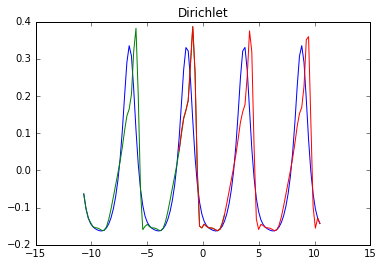

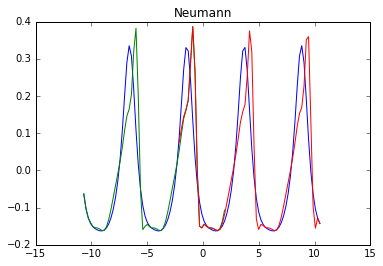

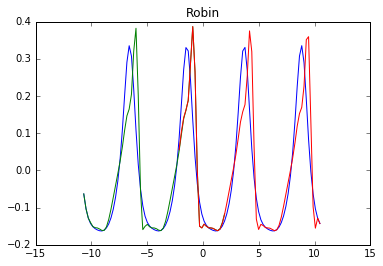

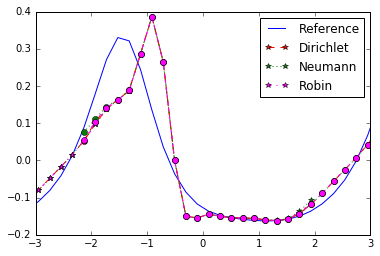

In [77]:
it=40

plt.figure()
plt.plot(x,uall1[:,it])
plt.plot(x1,uall1Dir[:,it],x2,uall2Dir[:,it])
#error = np.linalg.norm(uall1Dir[:,it]-uall1[0:Nddm,it]) + np.linalg.norm(uall2Dir[:,it]-uall1[Nddm-1:,it])
plt.title("Dirichlet")

plt.figure()
plt.plot(x,uall1[:,it])
plt.plot(x1,uall1Neu[:,it],x2,uall2Neu[:,it])
#error = np.linalg.norm(uall1Neu[:,it]-uall1[0:Nddm,it]) + np.linalg.norm(uall2Neu[:,it]-uall1[Nddm-1:,it])
plt.title("Neumann")

plt.figure()
plt.plot(x,uall1[:,it])
plt.plot(x1,uall1Rob[:,it],x2,uall2Rob[:,it])
#error = np.linalg.norm(uall1Rob[:,it]-uall1[0:Nddm,it]) + np.linalg.norm(uall2Rob[:,it]-uall1[Nddm-1:,it])
plt.title("Robin")

plt.figure()
plt.plot(x,uall1[:,it],label="Reference")
plt.plot(x1,uall1Dir[:,it],marker="*",linestyle="--",color="red",label="Dirichlet")
plt.plot(x2,uall2Dir[:,it],marker="o",linestyle="--",color="red")
plt.plot(x1,uall1Neu[:,it],marker="*",linestyle=":",color="green",label="Neumann")
plt.plot(x2,uall2Neu[:,it],marker="o",linestyle=":",color="green")
plt.plot(x1,uall1Rob[:,it],marker="*",linestyle="-.",color="magenta",label="Robin")
plt.plot(x2,uall2Rob[:,it],marker="o",linestyle="-.",color="magenta")
plt.xlim(-3.,3.)
plt.ylim(-0.2,0.4)
plt.legend(loc=0)

np.linalg.norm(uall1Dir[:,it]-uall1Rob[:,it])